# Problem Formulation for Tradespace Exploration using Rhodium

This notebook describes potential approaches of transforming the original problem formulation into ones which can better utilize functionalities provided by Rhodium.

## Problem Defination:
Finding the set of pareto equivalent policies in optimizing performance, cost, and risk, given an understanding of the requirements and constraints. 

In [1]:
from rhodium import *
import json
import math
from scipy.optimize import brentq as root
from j3 import J3
import numpy as np
import itertools
import csv

# plotting options
%matplotlib inline
sns.set()
sns.set_style('darkgrid')

## Approach 1: Enumeration without uncertainty
In this approach, we define a model which maps each decision alternative to a set of predefined metrics. The model takes in 10 lever parameters representing 10 decisions and returns a set of weighted sum of the metrics for the given policy.
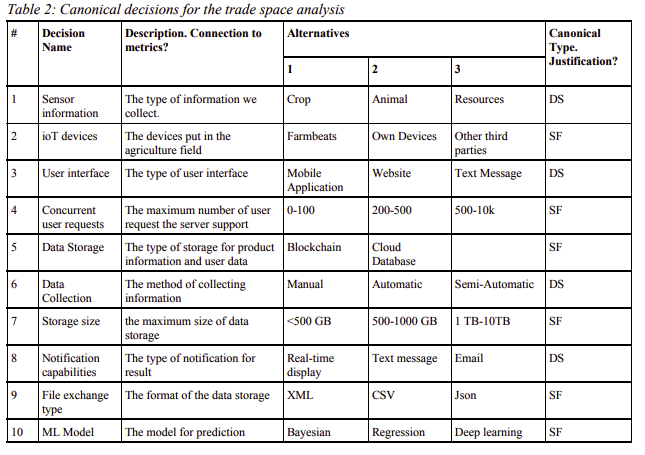

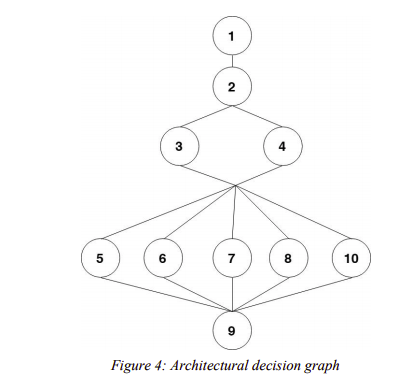

In [2]:
decisions = []
# with open("decisions.json", "r") as read_file:
    
read = open("decisions.json", "r")
decisions = json.load(read)['Decisions']
read.close()
    
print(decisions[0])

{'description': 'sensor information', 'type': 'DS', 'importance': 4, 'decisions': [{'alternative': 'Crop', 'performance': 1.05, 'KLOC': 5000, 'cost': 0, 'risk': 0}, {'alternative': 'Animal', 'performance': 1.08, 'KLOC': 1500, 'cost': 0, 'risk': 0}, {'alternative': 'Resources', 'performance': 1.1, 'KLOC': 5000, 'cost': 0, 'risk': 0}, {'alternative': 'Crop&Animal', 'performance': 1.1, 'KLOC': 5000, 'cost': 0, 'risk': 0}, {'alternative': 'Animal&Resources', 'performance': 1.15, 'KLOC': 1500, 'cost': 0, 'risk': 0}, {'alternative': 'Crop&Resources', 'performance': 1.14, 'KLOC': 5000, 'cost': 0, 'risk': 0}, {'alternative': 'Crop&Resources&Animal', 'performance': 1.2, 'KLOC': 5000, 'cost': 0, 'risk': 0}]}


In [ ]:
def farm_approach1(D1, D2, D3, D4, D5, D6, D7, D8, D9, D10):
    #policy = [D1[0], D2, D3[0], D4, D5, D6[0], D7, D8[0], D9, D10]
    policy = [D1, D2, D3, D4, D5, D6, D7, D8, D9, D10]
    performance = 1
    
    for i in range(9):
        performance *= decisions[i]['decisions'][policy[i]]['performance'] #* decisions[i]['importance']
    
    IoT_cost = decisions[1]['decisions'][D2]['cost']

    UI_cost = decisions[2]['decisions'][D3]['cost'] 
    
    DataStorage_cost = decisions[4]['decisions'][D5]['cost']
    
    ML_risk = decisions[9]['decisions'][D10]['risk']
    DataStorage_risk = decisions[4]['decisions'][D5]['risk']
    
    cost = IoT_cost + UI_cost + DataStorage_cost
    risk = ML_risk + DataStorage_risk
    
    return (performance, cost, risk)

In [ ]:
model = Model(farm_approach1)

model.parameters = [Parameter("D1"),
                    Parameter("D2"),
                    Parameter("D3"),
                    Parameter("D4"),
                    Parameter("D5"),
                    Parameter("D6"),
                    Parameter("D7"),
                    Parameter("D8"),
                    Parameter("D9"),
                    Parameter("D10")]

model.responses = [Response("performance", Response.MAXIMIZE),
                   Response("cost", Response.MINIMIZE),
                   Response("risk", Response.MINIMIZE)]
model.constraints = []

DS_choices = [[0],[1],[2],[0,1],[0,2],[1,2],[0,1,2]]
SF_choices = [0, 1, 2]

model.levers = [IntegerLever("D1", 0, 6, 1),
                IntegerLever("D2", 0, 2, 1),
                IntegerLever("D3", 0, 6, 1),
                IntegerLever("D4", 0, 2, 1),
                IntegerLever("D5", 0, 1, 1),
                IntegerLever("D6", 0, 6, 1),
                IntegerLever("D7", 0, 2, 1),
                IntegerLever("D8", 0, 6, 1),
                IntegerLever("D9", 0, 2, 1),
                IntegerLever("D10", 0, 2, 1)]

In [ ]:
output = optimize(model, "NSGAII", 100)
print("Found", len(output), "optimal policies!")
print(output)

In [ ]:
fig = scatter2d(model, output)

In [ ]:
fig = parallel_coordinates(model, output, colormap="rainbow", target="top")

In [ ]:
output.as_dataframe(['performance', 'cost', 'risk']).to_csv(r'results.csv')

## Approach 2: Enumeration with some uncertainties
In addtion to the 10 lever parameters defined in Approach 1, more parameters that are key to the system can be introduced, such as farm area, farm type, etc. These added parameters may involve uncertainties. Then, the model of this approad need to calculate metrics of decisions based on these new factors.

In [86]:
def farm_approach2(D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, 
                   numOfUsers = 1000,
                   latitude = 42.44):

    policy = [D1, D2, D3, D4, D5, D6, D7, D8, D9, D10]
    performance = 1
    
    #Account for latitude changes
    decisions[5]['decisions'][policy[5]]['performance'] *= (1 - (latitude/1000))
    decisions[2]['decisions'][policy[2]]['performance'] *= (1 - (latitude/1000))
    
    for i in range(9):
        performance *= decisions[i]['decisions'][policy[i]]['performance']
    
    IoT_cost = decisions[1]['decisions'][D2]['cost']

    UI_cost = decisions[2]['decisions'][D3]['cost'] 
    
    DataStorage_cost = decisions[4]['decisions'][D5]['cost']
    
    ML_risk = decisions[9]['decisions'][D10]['risk']
    DataStorage_risk = decisions[4]['decisions'][D5]['risk']
    
    matainance_cost = IoT_cost + (UI_cost + DataStorage_cost)/numOfUsers
    hardware_cost = IoT_cost * numOfUsers
    
    cost = matainance_cost + hardware_cost
    risk = ML_risk + DataStorage_risk
    
    return (performance, cost, risk)

In [87]:
model = Model(farm_approach2)

model.parameters = [Parameter("D1"),
                    Parameter("D2"),
                    Parameter("D3"),
                    Parameter("D4"),
                    Parameter("D5"),
                    Parameter("D6"),
                    Parameter("D7"),
                    Parameter("D8"),
                    Parameter("D9"),
                    Parameter("D10"),
                    Parameter("numOfUsers"),
                    Parameter("latitude")]

model.responses = [Response("performance", Response.MAXIMIZE),
                   Response("cost", Response.MINIMIZE),
                   Response("risk", Response.MINIMIZE)]
model.constraints = []

model.levers = [IntegerLever("D1", 0, 6, 1),
                IntegerLever("D2", 0, 2, 1),
                IntegerLever("D3", 0, 6, 1),
                IntegerLever("D4", 0, 2, 1),
                IntegerLever("D5", 0, 1, 1),
                IntegerLever("D6", 0, 6, 1),
                IntegerLever("D7", 0, 2, 1),
                IntegerLever("D8", 0, 6, 1),
                IntegerLever("D9", 0, 2, 1),
                IntegerLever("D10", 0, 2, 1)]

In [97]:
output = optimize(model, "NSGAII", 100)
print("Found", len(output), "optimal policies!")

output.as_dataframe(['performance', 'cost', 'risk']).to_csv(r'results.csv')

here
Found 8 optimal policies!


#### Scenario Discovery & SOW


In [89]:
model.uncertainties = [UniformUncertainty("numOfUsers", 1000, 100),
                       UniformUncertainty("latitude", 40, 3)]

In [95]:
policy = {"D1" : 4,"D2":0, "D3":3, "D4":1, "D5":0, "D6":4, "D7":2, "D8":4, "D9":0, "D10":0}
result = evaluate(model, policy)
print(result)

{'D1': 4, 'D2': 0, 'D3': 3, 'D4': 1, 'D5': 0, 'D6': 4, 'D7': 2, 'D8': 4, 'D9': 0, 'D10': 0, 'performance': 2.413812640829503e-263, 'cost': 500880.0, 'risk': 0.15005}


In [96]:
SOWs = sample_lhs(model, 1000)
print(SOWs)

Index 0:
    numOfUsers: 998.7775216887218
    latitude: 25.67350333118278
Index 1:
    numOfUsers: 430.83494377160173
    latitude: 32.726037854602474
Index 2:
    numOfUsers: 644.2864454158564
    latitude: 20.823889804905424
Index 3:
    numOfUsers: 754.6001350140775
    latitude: 11.280793393274575
Index 4:
    numOfUsers: 961.6299321463104
    latitude: 27.810851006674845
Index 5:
    numOfUsers: 175.82812839207986
    latitude: 26.233179916594743
Index 6:
    numOfUsers: 992.7357736998786
    latitude: 14.050239866260448
Index 7:
    numOfUsers: 103.86058923527162
    latitude: 8.296124820958784
Index 8:
    numOfUsers: 799.1001555088255
    latitude: 8.408261910477211
Index 9:
    numOfUsers: 923.3887020482259
    latitude: 35.98671615710974
Index 10:
    numOfUsers: 521.9058803768033
    latitude: 7.003698667939766
Index 11:
    numOfUsers: 779.8128318227132
    latitude: 33.443632382212996
Index 12:
    numOfUsers: 440.6040560279631
    latitude: 38.871348606376635
Index 13:
 

In [92]:
results = evaluate(model, update(SOWs, policy))
print(results)

Index 0:
    D1: 4
    D2: 0
    D3: 3
    D4: 1
    D5: 0
    D6: 4
    D7: 2
    D8: 4
    D9: 0
    D10: 0
    numOfUsers: 431.8644083105164
    latitude: 28.538331660758057
    performance: 2.1143822989344353e-244
    cost: 217312.10996061636
    risk: 0.15005
Index 1:
    D1: 4
    D2: 0
    D3: 3
    D4: 1
    D5: 0
    D6: 4
    D7: 2
    D8: 4
    D9: 0
    D10: 0
    numOfUsers: 731.6362989687353
    latitude: 23.993571583675916
    performance: 2.014136364714292e-244
    cost: 366837.53322808794
    risk: 0.15005
Index 2:
    D1: 4
    D2: 0
    D3: 3
    D4: 1
    D5: 0
    D6: 4
    D7: 2
    D8: 4
    D9: 0
    D10: 0
    numOfUsers: 131.36757248724427
    latitude: 4.155108646466907
    performance: 1.9974332277849614e-244
    cost: 69076.43313360632
    risk: 0.15005
Index 3:
    D1: 4
    D2: 0
    D3: 3
    D4: 1
    D5: 0
    D6: 4
    D7: 2
    D8: 4
    D9: 0
    D10: 0
    numOfUsers: 985.01139017152
    latitude: 6.269432442663849
    performance: 1.97246619310161

In [93]:
results.as_dataframe(['performance', 'cost', 'numOfUsers', 'latitude']).to_csv(r'SD_results.csv')

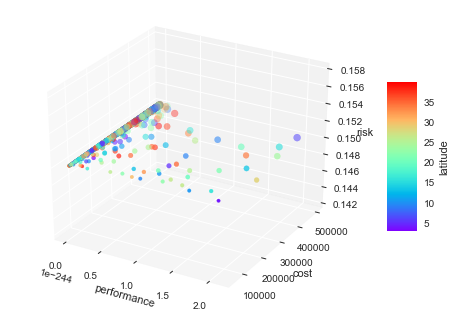

In [94]:
plot3fig = scatter3d(model, results, c = 'latitude', s = 'numOfUsers')

In [ ]:
fig = pairs(model, output,
            brush=[Brush("reliability > 0.2"), Brush("reliability <= 0.2")])